# Introduction



In this home assignment you are asked to complete two tasks:

1. Write a **Python script** to create labels for a given set of liquidity pool addresses
1. Write a **SQL query** to show how much fees MetaMask has earned from their swap service in a given time interval

You can complete the assignment in this notebook, or you can download a copy of it and complete it offline. In either case we want you to present and take us through your solution in the next interview.

# Setup

To work in this notebook: Start by running this section step by step to set up.

1. Install dependencies with `pip`
1. Define constants
1. Authenticate with your google account for BigQuery



In [ ]:
%%capture
### (1) Install dependencies and restart runtime
import os

!pip install -q --upgrade jsonschema==3.2.0
!pip install -q --upgrade web3==5.23.0

os.kill(os.getpid(), 9)  # Hack to restart the runtime after install

In [1]:
### (2) Define constants

# Infura free plan API key. Don't abuse this please!
NODE_ENDPOINT = "https://mainnet.infura.io/v3/47ae223686054ce8b960a29841c683cd"

# Addresses for Problem 1
ADDRESSES = {
    "PROTOCOL_A": [        
      "0x94b0a3d511b6ecdb17ebf877278ab030acb0a878",
      "0x9928e4046d7c6513326ccea028cd3e7a91c7590a",
      "0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc",
    ],
    "PROTOCOL_B": [
      "0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8",
      "0xcbcdf9626bc03e24f779434178a73a0b4bad62ed",
      "0x7858e59e0c01ea06df3af3d20ac7b0003275d4bf",
    ],
    "PROTOCOL_C": [ 
      "0xceff51756c56ceffca006cd410b03ffc46dd3a58",
      "0x795065dcc9f64b5614c407a6efdc400da6221fb0",
      "0x397ff1542f962076d0bfe58ea045ffa2d347aca0",
    ],
    "PROTOCOL_D": [ 
      "0x0ef1b8a0e726fc3948e15b23993015eb1627f210",
      "0x1f629794b34ffb3b29ff206be5478a52678b47ae",
      "0x6a11f3e5a01d129e566d783a7b6e8862bfd66cca",
    ],
    "PROTOCOL_E": [ 
      "0x75116bd1ab4b0065b44e1a4ea9b4180a171406ed",
      "0xbeabef3fc02667d8bd3f702ae0bb2c4edb3640cc",
      "0x31631b3dd6c697e574d6b886708cd44f5ccf258f",
    ],
}

In [2]:
### (3) Authenticate with Google Cloud Platform to run BigQuery queries
from google.colab import auth
auth.authenticate_user()

**Now collapse the Setup section and move on:** [Back to top](#scrollTo=Q4FArHYYIkmc)

# Task 1



For the set of liquidity pool contract addresses in `ADDRESSES`, produce a set of descriptive text labels including information about what protocol they belong to and what tokens they contain. The liquidity pools belong to five different protocols `PROTOCOL_A`, ..., `PROTOCOL_E`, and you have to manually figure out which is which.

A good format for labels is the following:
```
  <Protocol>: <Token Pair Symbols> Liquidity Pool
```
For example:
```
  SushiSwap: ETH-USDC Liquidity Pool
  1inch: USDC-USDT Liquidity Pool
```

- Use code from the [Appendix](#scrollTo=_XR-NE80LRC6) to get started.
- Use [Etherscan](https://etherscan.io/) to find information about the contracts
- Refer to the [ABI spec](https://docs.soliditylang.org/en/v0.5.3/abi-spec.html) if necessary

In [73]:

# Your code goes here:

from web3 import Web3

w3 = Web3(Web3.HTTPProvider(NODE_ENDPOINT))

def create_constant_abi(output_name, output_type):
  '''
  '''
  return {
    "constant": True,
    "inputs": [],
    "name": output_name,
    "outputs": [
      {
        "name": output_name,
        "type": output_type
      }
    ],
    "type": "function"
  }

def get_token_symbol(token_address):
  '''
  '''
  token_symbol_abi = [create_constant_abi("symbol", "string")] #symbol
  token_contract = w3.eth.contract(
      w3.toChecksumAddress(token_address),
      abi=token_symbol_abi
  )
  token_symbol = token_contract.functions.symbol().call()
  return token_symbol


def generate_pool_description(address):
  '''
  '''
  symbol_pools = ["1inch", "mooniswap"]

  pool_description = {
      "pool_name": None,
      "pool_symbol_0": None,
      "pool_symbol_1": None
  }
  
  pool_abi = [
    #token0, token1
    create_constant_abi(f"token{token}", "address") for token in range(0,2)
  ]
  pool_abi.append(create_constant_abi("name", "string")) #name

  pool_contract = w3.eth.contract(w3.toChecksumAddress(address), abi=pool_abi)
  try:
    pool_name = pool_contract.functions.name().call()
    pool_description["pool_name"] = pool_name.split(' ')[0] #clean name
    # pool_description["pool_name"] = pool_name
  except Exception as e:
    # couldn't find pool name
    pool_name = ""
  
  if any(pool in pool_name.lower() for pool in symbol_pools):
    pool_symbol = get_token_symbol(address)
    token_0_symbol = pool_symbol.split('-')[-2]
    token_1_symbol = pool_symbol.split('-')[-1]
  
  else:
    token_0_address = pool_contract.functions.token0().call()
    token_1_address = pool_contract.functions.token1().call()
    token_0_symbol = get_token_symbol(token_0_address)
    token_1_symbol = get_token_symbol(token_1_address)

  pool_description["pool_symbol_0"] = token_0_symbol
  pool_description["pool_symbol_1"] = token_1_symbol

  return pool_description

In [74]:
for protocol, address_list in ADDRESSES.items():
  
  print(protocol)
  for address in address_list:
    description = generate_pool_description(address)
    if protocol == "PROTOCOL_B":
      pool_name = "Uniswap"
    else:
      pool_name = description['pool_name']

    print(
        f"{pool_name}: {description['pool_symbol_0']}-{description['pool_symbol_1']}"
    )

PROTOCOL_A
Uniswap: FEI-WETH
Uniswap: FEI-TRIBE
Uniswap: USDC-WETH
PROTOCOL_B
Uniswap: USDC-WETH
Uniswap: WBTC-WETH
Uniswap: USDC-USDT
PROTOCOL_C
SushiSwap: WBTC-WETH
SushiSwap: SUSHI-WETH
SushiSwap: USDC-WETH
PROTOCOL_D
1inch: ETH-1INCH
1inch: LDO-0xae7ab96520de3a18e5e111b5eaab095312d7fe84
1inch: ETH-WBTC
PROTOCOL_E
Mooniswap: ETH-DAI
Mooniswap: ETH-USDT
Mooniswap: DAI-USDC


Note on `PROTOCOL_D` "0xae7ab96520de3a18e5e111b5eaab095312d7fe84"

Manually found that was "stETH": https://etherscan.io/address/0xae7ab96520de3a18e5e111b5eaab095312d7fe84

# Task 2

Write a SQL query that returns metrics on fees earned by MetaMask from their swap service during the month of August 2021. For this assignment, we're only interested in fees paid in ETH and WETH.

Your query should return:
- Sum of fees per day
- Average fee per transaction per day
- _Bonus if you have time:_ Cumulative (rolling sum) sum of fees per day

You can use the following addresses:
- [Metamask Swap Router](https://etherscan.io/address/0x881d40237659c251811cec9c364ef91dc08d300c)
- [Metamask Swap Contract](https://etherscan.io/address/0x74de5d4fcbf63e00296fd95d33236b9794016631)
- [Metamask Swap Fees]( https://etherscan.io/address/0x11ededebf63bef0ea2d2d071bdf88f71543ec6fb)

Some tips to get started:
- Use code from the [Appendix](#scrollTo=9GYZna3554ZE) to get started
- Study examples of swaps involving [ETH](https://etherscan.io/tx/0x414a65d5d93c805c0de2696cce2c92cb7f9b522724b271d0a29538c4ebea6587) and [WETH](https://etherscan.io/tx/0xfa79daf2162e86c53246d04f5b0ff55ded73569d5b05d250fa0ab4d5f46a809d)
- Query the tables in the public
[crypto_ethereum](https://console.cloud.google.com/marketplace/product/ethereum/crypto-ethereum-blockchain) dataset
- You will need to query `transactions`, `traces` and `token_transfers`


The source tables are quite large, so remember to use a **date partition filter** to minimize query cost.




In [122]:
# Your code goes here:

#0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2 WETH

%%bigquery resulting_df --project PROJECT

SELECT 
  transaction_hash,
  fee,
  block_timestamp,
  block_date
FROM
(
SELECT
  transaction_hash,
  value / 1000000000000000000 as fee,
  UNIX_SECONDS(block_timestamp) as block_timestamp,
  DATE(block_timestamp) block_date
FROM 
  `bigquery-public-data.crypto_ethereum.traces`
WHERE 
  DATE(block_timestamp) >= "2021-08-01" AND
  DATE(block_timestamp) <= "2021-08-31" AND
  from_address = "0x74de5d4fcbf63e00296fd95d33236b9794016631" AND
  to_address = "0x11ededebf63bef0ea2d2d071bdf88f71543ec6fb" AND
  value > 0
)
UNION ALL
(
SELECT 
  transaction_hash,
  CAST(value AS INT64) / 1000000000000000000 as fee,
  UNIX_SECONDS(block_timestamp) as block_timestamp,
  DATE(block_timestamp) block_date
FROM 
  `bigquery-public-data.crypto_ethereum.token_transfers`
WHERE 
  DATE(block_timestamp) >= "2021-08-01" AND
  DATE(block_timestamp) <= "2021-08-31" AND
  token_address = "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2" AND
  from_address = "0x74de5d4fcbf63e00296fd95d33236b9794016631" AND
  to_address = "0x11ededebf63bef0ea2d2d071bdf88f71543ec6fb"
)
ORDER BY block_date ASC

In [128]:
aggregated_df = resulting_df.groupby('block_date').agg(
  transactions_per_day=("transaction_hash", "count"),
  total_fee=("fee", "sum"),
).reset_index()
aggregated_df["fees_per_transactions"] = aggregated_df["total_fee"] / aggregated_df["transactions_per_day"]
aggregated_df["cumulative_fees"] = aggregated_df["total_fee"].cumsum()


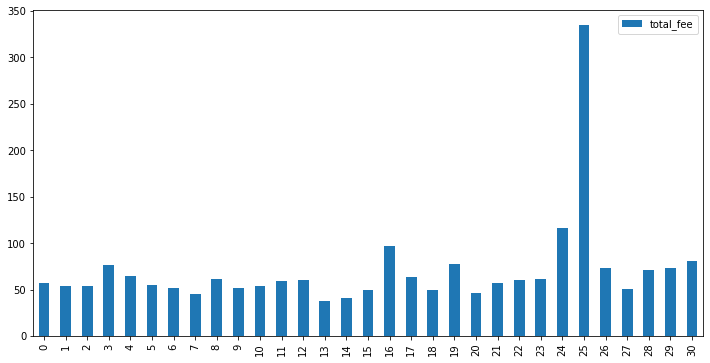

In [116]:
aggregated_df.plot(
    y='total_fee',
    kind='bar',
    figsize=(12,6)
)

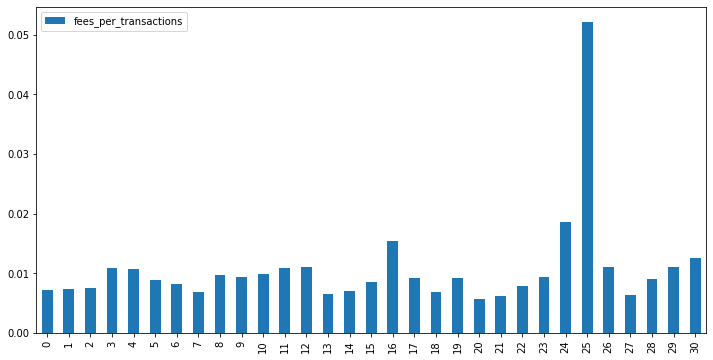

In [115]:
aggregated_df.plot(
    y='fees_per_transactions',
    kind='bar',
    figsize=(12,6)
)

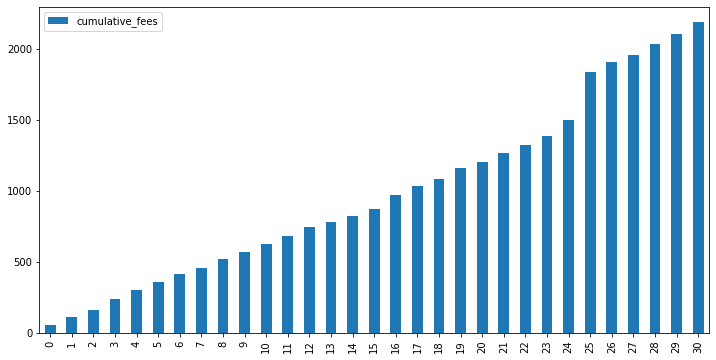

In [129]:
aggregated_df.plot(
    y='cumulative_fees',
    kind='bar',
    figsize=(12,6)
)

In [110]:
average_fee_per_transaction_pandas = resulting_df.groupby(['transaction_hash', 'block_date'])['fee'].mean().reset_index(name='avg_fee_per_transaction_per_day')

In [111]:
average_fee_per_transaction_pandas.head()

,transaction_hash,block_date,avg_fee_per_transaction_per_day
0,0x00000fb91213bb2b1d9e7e0b026bc8e0c685ab4ffebe...,2021-08-18,0.000234
1,0x0000213657e1cedd18b5f870a768cf9506cb4da96cd2...,2021-08-10,0.000210
2,0x000026eb89aadd0ca4e42aa2b99c974c425696205ddd...,2021-08-01,0.000667
3,0x00004922a26a83cfca110c81bd89d3c30c75c2b6644a...,2021-08-22,0.002188
4,0x00007a8cf872a692b0ece86c5094317d55d9655929ce...,2021-08-31,0.000612


In [131]:
%%bigquery fees_per_day_bq --project PROJECT

SELECT
  SUM(fee) total_fee,
  block_date
FROM (
  SELECT
    transaction_hash,
    fee,
    block_timestamp,
    block_date
  FROM (
    SELECT
      transaction_hash,
      value / 1000000000000000000 AS fee,
      UNIX_SECONDS(block_timestamp) AS block_timestamp,
      DATE(block_timestamp) block_date
    FROM
      `bigquery-public-data.crypto_ethereum.traces`
    WHERE
      DATE(block_timestamp) >= "2021-08-01"
      AND DATE(block_timestamp) <= "2021-08-31"
      AND from_address = "0x74de5d4fcbf63e00296fd95d33236b9794016631"
      AND to_address = "0x11ededebf63bef0ea2d2d071bdf88f71543ec6fb"
      AND value > 0 )
  UNION ALL (
    SELECT
      transaction_hash,
      CAST(value AS INT64) / 1000000000000000000 AS fee,
      UNIX_SECONDS(block_timestamp) AS block_timestamp,
      DATE(block_timestamp) block_date
    FROM
      `bigquery-public-data.crypto_ethereum.token_transfers`
    WHERE
      DATE(block_timestamp) >= "2021-08-01"
      AND DATE(block_timestamp) <= "2021-08-31"
      AND token_address = "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"
      AND from_address = "0x74de5d4fcbf63e00296fd95d33236b9794016631"
      AND to_address = "0x11ededebf63bef0ea2d2d071bdf88f71543ec6fb" ) )
GROUP BY
  block_date

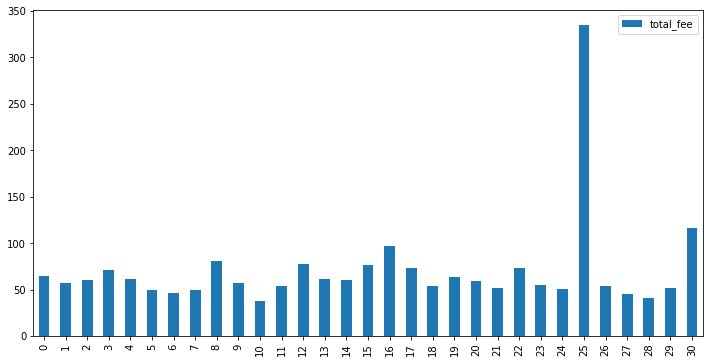

In [136]:
fees_per_day_bq.plot(
    y='total_fee',
    kind='bar',
    figsize=(12,6)
)

In [137]:
%%bigquery average_fee_per_transaction_bq --project PROJECT

SELECT
  AVG(fee) total_fee,
  transaction_hash,
  block_date
FROM (
  SELECT
    transaction_hash,
    fee,
    block_timestamp,
    block_date
  FROM (
    SELECT
      transaction_hash,
      value / 1000000000000000000 AS fee,
      UNIX_SECONDS(block_timestamp) AS block_timestamp,
      DATE(block_timestamp) block_date
    FROM
      `bigquery-public-data.crypto_ethereum.traces`
    WHERE
      DATE(block_timestamp) >= "2021-08-01"
      AND DATE(block_timestamp) <= "2021-08-31"
      AND from_address = "0x74de5d4fcbf63e00296fd95d33236b9794016631"
      AND to_address = "0x11ededebf63bef0ea2d2d071bdf88f71543ec6fb"
      AND value > 0 )
  UNION ALL (
    SELECT
      transaction_hash,
      CAST(value AS INT64) / 1000000000000000000 AS fee,
      UNIX_SECONDS(block_timestamp) AS block_timestamp,
      DATE(block_timestamp) block_date
    FROM
      `bigquery-public-data.crypto_ethereum.token_transfers`
    WHERE
      DATE(block_timestamp) >= "2021-08-01"
      AND DATE(block_timestamp) <= "2021-08-31"
      AND token_address = "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"
      AND from_address = "0x74de5d4fcbf63e00296fd95d33236b9794016631"
      AND to_address = "0x11ededebf63bef0ea2d2d071bdf88f71543ec6fb" ) )
GROUP BY
  transaction_hash, block_date

In [138]:
average_fee_per_transaction_bq.head()

,total_fee,transaction_hash,block_date
0,0.000415,0xec445c23c139ded99c1d38414785d8efb8db8360da4e...,2021-08-16
1,0.000526,0x53d9426eeecda199fb755c0dc26e527c63d0486ac418...,2021-08-16
2,0.006182,0xf738039d71896804958d955426ffb6f0304ddb665317...,2021-08-29
3,0.000438,0xe7b76d793ac1d106ae8377e5444acdf99064c3d422d4...,2021-08-29
4,0.000139,0x8b373708183eeb44a814a4501c15c6045d498daf9fb5...,2021-08-29


In [139]:
%%bigquery total_fees_over_total_transactions_per_day_bq --project PROJECT

SELECT
  SUM(fee) / COUNT(DISTINCT transaction_hash) fees_per_transactions,
  block_date
FROM (
  SELECT
    transaction_hash,
    fee,
    block_timestamp,
    block_date
  FROM (
    SELECT
      transaction_hash,
      value / 1000000000000000000 AS fee,
      UNIX_SECONDS(block_timestamp) AS block_timestamp,
      DATE(block_timestamp) block_date
    FROM
      `bigquery-public-data.crypto_ethereum.traces`
    WHERE
      DATE(block_timestamp) >= "2021-08-01"
      AND DATE(block_timestamp) <= "2021-08-31"
      AND from_address = "0x74de5d4fcbf63e00296fd95d33236b9794016631"
      AND to_address = "0x11ededebf63bef0ea2d2d071bdf88f71543ec6fb"
      AND value > 0 )
  UNION ALL (
    SELECT
      transaction_hash,
      CAST(value AS INT64) / 1000000000000000000 AS fee,
      UNIX_SECONDS(block_timestamp) AS block_timestamp,
      DATE(block_timestamp) block_date
    FROM
      `bigquery-public-data.crypto_ethereum.token_transfers`
    WHERE
      DATE(block_timestamp) >= "2021-08-01"
      AND DATE(block_timestamp) <= "2021-08-31"
      AND token_address = "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"
      AND from_address = "0x74de5d4fcbf63e00296fd95d33236b9794016631"
      AND to_address = "0x11ededebf63bef0ea2d2d071bdf88f71543ec6fb" ) )
GROUP BY
  block_date

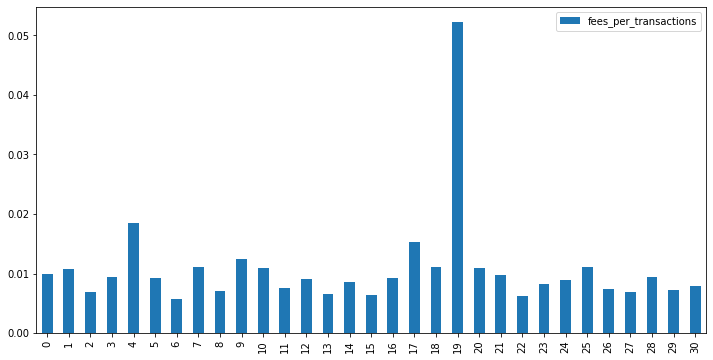

In [140]:
total_fees_over_total_transactions_per_day_bq.plot(
    y='fees_per_transactions',
    kind='bar',
    figsize=(12,6)
)

In [142]:
%%bigquery cumulative_sum_fees_per_day_bq --project PROJECT

SELECT
  SUM(total_fee) OVER (ORDER BY block_date ASC) as cumulative_fees,
  block_date
FROM (
  SELECT
    SUM(fee) total_fee,
    block_date
  FROM (
    SELECT
      transaction_hash,
      fee,
      block_timestamp,
      block_date
    FROM (
      SELECT
        transaction_hash,
        value / 1000000000000000000 AS fee,
        UNIX_SECONDS(block_timestamp) AS block_timestamp,
        DATE(block_timestamp) block_date
      FROM
        `bigquery-public-data.crypto_ethereum.traces`
      WHERE
        DATE(block_timestamp) >= "2021-08-01"
        AND DATE(block_timestamp) <= "2021-08-31"
        AND from_address = "0x74de5d4fcbf63e00296fd95d33236b9794016631"
        AND to_address = "0x11ededebf63bef0ea2d2d071bdf88f71543ec6fb"
        AND value > 0 )
    UNION ALL (
      SELECT
        transaction_hash,
        CAST(value AS INT64) / 1000000000000000000 AS fee,
        UNIX_SECONDS(block_timestamp) AS block_timestamp,
        DATE(block_timestamp) block_date
      FROM
        `bigquery-public-data.crypto_ethereum.token_transfers`
      WHERE
        DATE(block_timestamp) >= "2021-08-01"
        AND DATE(block_timestamp) <= "2021-08-31"
        AND token_address = "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"
        AND from_address = "0x74de5d4fcbf63e00296fd95d33236b9794016631"
        AND to_address = "0x11ededebf63bef0ea2d2d071bdf88f71543ec6fb" ) )
  GROUP BY
    block_date )

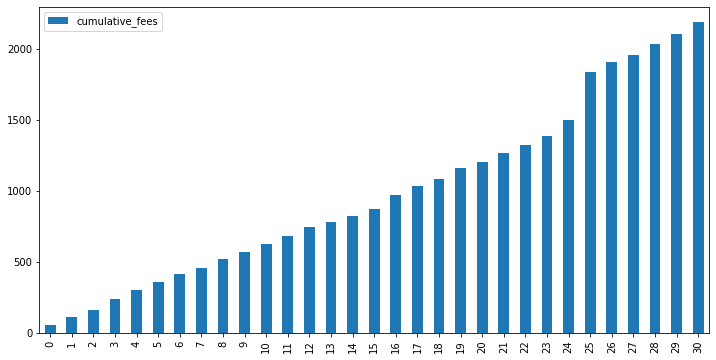

In [143]:
cumulative_sum_fees_per_day_bq.plot(
    y='cumulative_fees',
    kind='bar',
    figsize=(12,6)
)